# Project Review 2 - Statistical Analysis of Data

## Exploring possible correlation between vulnerability publish date and commit frequency

### Seth Goodwin

In [1]:
import pandas as pd
import datetime as dt
from pandas.io.json import json_normalize

#### Read in GitHub commit data.

In [2]:
commits = pd.read_csv('../../ipynb/data/revision_cleaned.csv', usecols=[1,2,3], parse_dates=['date'])
commits.columns = ['id', 'commit_date', 'message']
print(commits.head())

                                         id         commit_date  \
0  01714ff5fd94a846f7dc3456a52e6f2dcd36ca0b 2015-04-02 01:11:50   
1  01d76a45b817be788eab3e27a93e41c74a6d8957 2010-08-14 17:15:31   
2  03ac0bf5d03af97bc7dc7c5aa67d8ee346f8cd1c 2013-09-27 17:02:55   
3  05c9110ba2615d42af41a77138bc62dd18278320 2011-10-25 20:11:52   
4  06de8d8e88d5b6311ea3feae369c85d157c9dfe3 2017-10-31 20:29:21   

                                             message  
0  Implement dask.array.take\n\nIn principle, we ...  
1                               Convert to spaces.\n  
2  Merge pull request #4887 from cpcloud/groupby-...  
3  Merge pull request #162 from gabrielhurley/use...  
4  Update patch set 1\n\nPatch Set 1: Presubmit-V...  


#### The two functions below reads in all the NVD data, cleans and extracts the appropriate columns, and returns the data as a single dataframe.

In [3]:
import glob

def import_nvd():
    path = '../../ipynb/data/nvd/'
    all_nvds = glob.glob(path+'*.json')
    l = []
    
    for filename in all_nvds:
        nvd_df = pd.read_json(filename)
        nvd_df = clean_nvd(nvd_df)
        l.append(nvd_df)
    
    return pd.concat(l, ignore_index=True)

def clean_nvd(df):
    df = json_normalize(df['CVE_Items'])
    df = df[['cve.CVE_data_meta.ID', 'publishedDate', 'impact.baseMetricV2.cvssV2.baseScore', 'cve.references.reference_data']]
    df.columns = ['cve_id', 'published_date', 'base_score', 'reference_links']
    df['published_date'] = df['published_date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%dT%H:%MZ'))
    
    return df

#### This function resamples column data.

In [4]:
def resample(col, x):
    return col.value_counts().resample(x).apply('count')

In [5]:
all_vulns = import_nvd()
print(all_vulns.head())

          cve_id      published_date  base_score  \
0  CVE-2017-0001 2017-03-17 00:59:00         7.2   
1  CVE-2017-0002 2017-01-10 21:59:00         6.8   
2  CVE-2017-0003 2017-01-10 21:59:00         9.3   
3  CVE-2017-0004 2017-01-10 21:59:00         7.8   
4  CVE-2017-0005 2017-03-17 00:59:00         6.9   

                                     reference_links  
0  [{'url': 'http://www.securityfocus.com/bid/960...  
1  [{'url': 'http://www.securityfocus.com/bid/952...  
2  [{'url': 'http://fortiguard.com/advisory/FG-VD...  
3  [{'url': 'http://www.securityfocus.com/bid/953...  
4  [{'url': 'http://www.securityfocus.com/bid/960...  


#### New software vulnerabilities discovered each year.

In [6]:
resample(all_vulns['published_date'],'y')

1988-12-31       2
1989-12-31       3
1990-12-31       9
1991-12-31      14
1992-12-31      12
1993-12-31      12
1994-12-31      22
1995-12-31      21
1996-12-31      64
1997-12-31     116
1998-12-31     132
1999-12-31     256
2000-12-31     197
2001-12-31     194
2002-12-31      89
2003-12-31      91
2004-12-31     186
2005-12-31     409
2006-12-31     828
2007-12-31     807
2008-12-31     670
2009-12-31     670
2010-12-31     471
2011-12-31     415
2012-12-31     653
2013-12-31     692
2014-12-31     870
2015-12-31     758
2016-12-31     650
2017-12-31    1832
2018-12-31    2502
2019-12-31     862
Freq: A-DEC, Name: published_date, dtype: int64

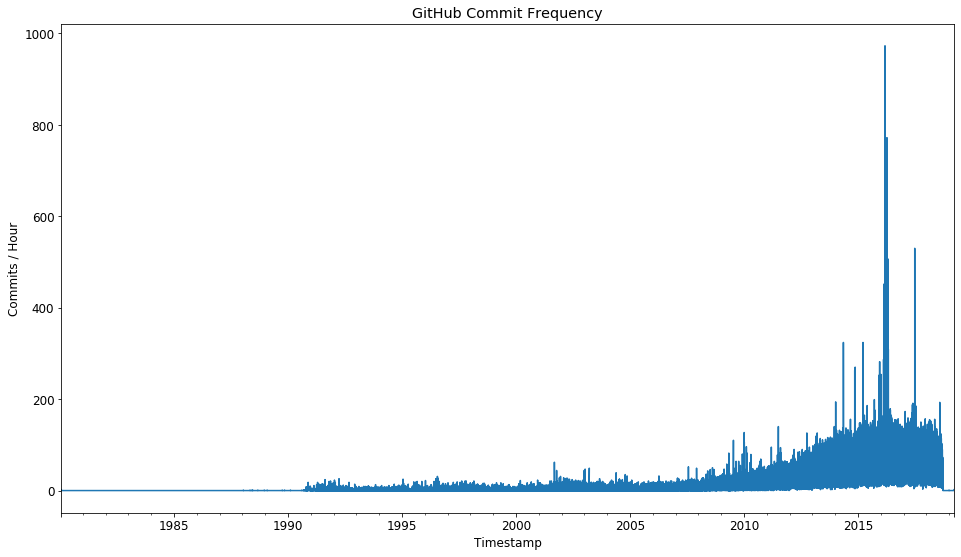

In [10]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [16,9]
plt.rcParams.update({'font.size': 12})

commits_h = resample(commits['commit_date'], 'h')
commits_h.plot()
plt.title('GitHub Commit Frequency')
plt.ylabel('Commits / Hour')
plt.xlabel('Timestamp')
plt.show()

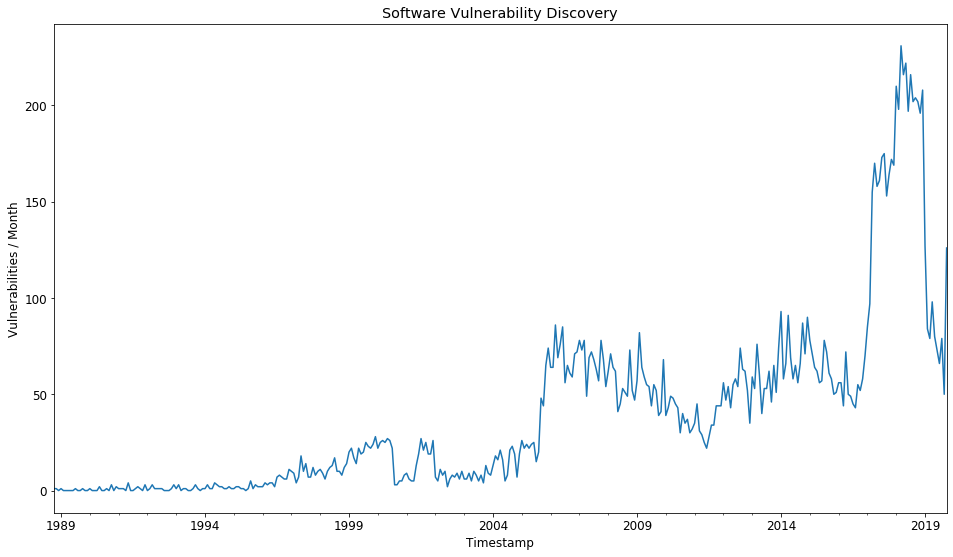

In [11]:
vulns_m = resample(all_vulns['published_date'], 'm')
vulns_m.plot()
plt.title('Software Vulnerability Discovery')
plt.ylabel('Vulnerabilities / Month')
plt.xlabel('Timestamp')
plt.show()

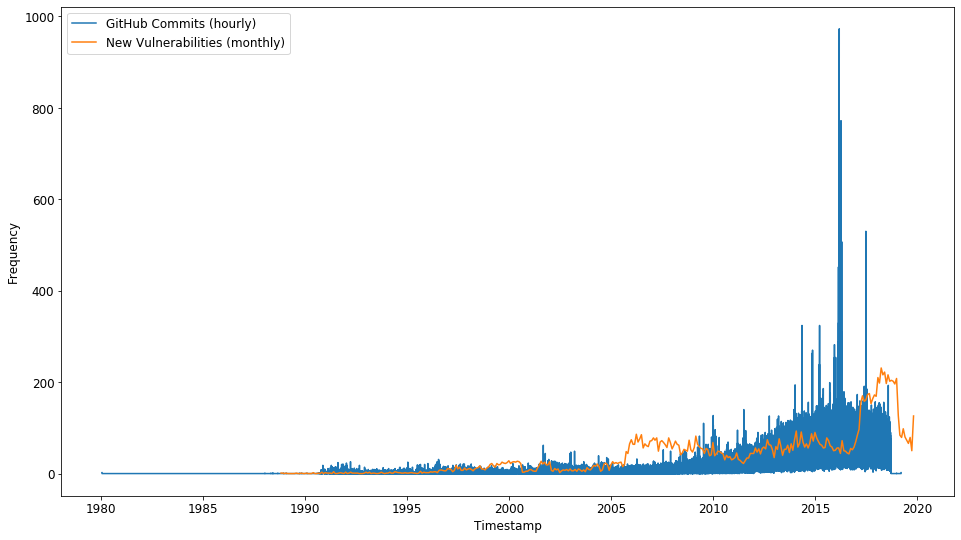

In [12]:
plt.plot(commits_h, label='GitHub Commits (hourly)')
plt.plot(vulns_m, label='New Vulnerabilities (monthly)')
plt.legend(loc='upper left')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.show()

#### This function extracts vulnerabilities that have been patched by a GitHub commit.

In [13]:
import re

def get_patched_vulns(df):
    row_list = []
    for index, row in df.iterrows():
        for x in row['reference_links']:
            url = x['url']
            git = (re.search('https://github.com/[a-z0-9(/)A-Z]*/commit/[a-z0-9]*', url))
            if git:
                if 'Patch' in x['tags']:
                    row_list.append(row)
                    row['reference_links'] = git.group()
                
    patched_vulns = pd.DataFrame(row_list)
    patched_vulns.columns = ['cve_id', 'published_date', 'base_score', 'url']
    return patched_vulns.reset_index(drop='True')

In [14]:
patched_vulns = get_patched_vulns(all_vulns)
# this dataframe contains vulnerabilities that are are patched by a GitHub commit
patched_vulns

,cve_id,published_date,base_score,url
0,CVE-2017-0028,2017-07-17 13:18:00,10.0,https://github.com/Microsoft/ChakraCore/commit...
1,CVE-2017-0152,2017-07-17 13:18:00,9.3,https://github.com/Microsoft/ChakraCore/commit...
2,CVE-2017-0196,2017-07-17 13:18:00,4.3,https://github.com/Microsoft/ChakraCore/commit...
3,CVE-2017-0375,2017-06-09 17:29:00,5.0,https://github.com/torproject/tor/commit/79b59...
4,CVE-2017-0376,2017-06-09 17:29:00,5.0,https://github.com/torproject/tor/commit/56a7c...
...,...,...,...,...
2618,CVE-2018-9918,2018-04-10 18:29:00,6.8,https://github.com/qpdf/qpdf/commit/b4d6cf6836...
2619,CVE-2018-9988,2018-04-10 19:29:00,5.0,https://github.com/ARMmbed/mbedtls/commit/a109...
2620,CVE-2018-9988,2018-04-10 19:29:00,5.0,https://github.com/ARMmbed/mbedtls/commit/a109...
2621,CVE-2018-9989,2018-04-10 19:29:00,5.0,https://github.com/ARMmbed/mbedtls/commit/740b...


#### Plotting software vulnerabilities that have been patched by a GitHub commit.

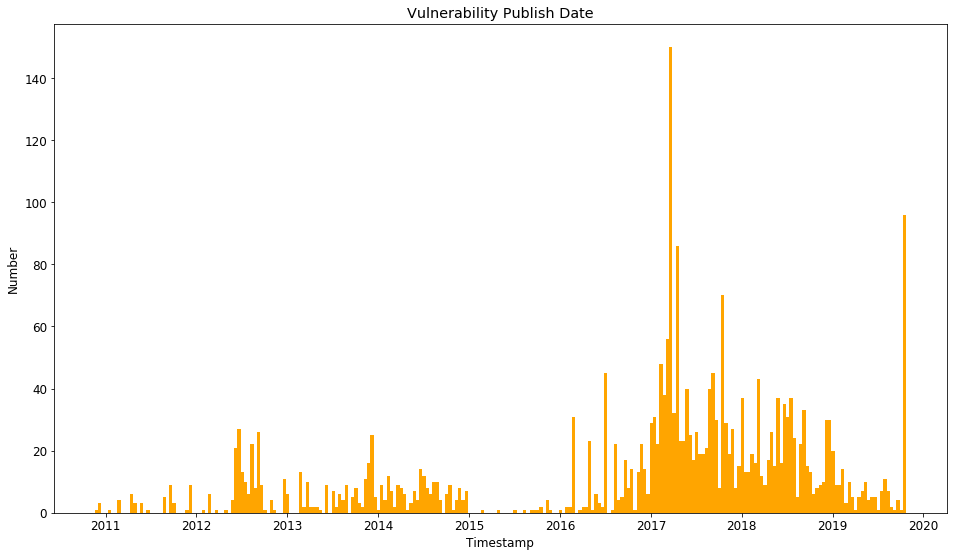

In [15]:
plt.hist(patched_vulns['published_date'], bins=250, color='orange')
plt.xlabel('Timestamp')
plt.ylabel('Number')
plt.title('Vulnerability Publish Date')
plt.show()

#### Crawl each GitHub url and get the commit date from each url. This is the date where each vulnerability is patched.

In [16]:
import requests
from bs4 import BeautifulSoup

commit_date = []

for index, row in patched_vulns.iterrows():
    url = row['url']

    page = requests.get(url)

    soup = BeautifulSoup(page.text, 'html.parser')
        
    if not isinstance(soup.find('relative-time'), type(None)): 
        c_date = soup.find('relative-time').text.replace(',', '')
        commit_date.append(c_date)
    else:
        commit_date.append('')
    
c_dates = pd.DataFrame(commit_date)
c_dates.columns = ['commit_date']
print(c_dates.head())

   commit_date
0  Jan 12 2017
1   Mar 9 2017
2  Jan 19 2017
3   Jun 5 2017
4   Jun 5 2017


#### Convert each date to datetime objects.

In [17]:
from datetime import datetime

for index, row in c_dates.iterrows():
    date = str(row['commit_date'])
    
    if date != '':
        datetimeObj = datetime.strptime(date, '%b %d %Y')
        date = datetimeObj.date()

        row['commit_date'] = date
        
print(c_dates.head())

  commit_date
0  2017-01-12
1  2017-03-09
2  2017-01-19
3  2017-06-05
4  2017-06-05


In [18]:
# we no longer need the GitHub urls
del patched_vulns['url']

# add the GitHub commit dates to dataframe
patched_vulns['commit_date'] = c_dates

from datetime import date

patched_vulns = patched_vulns[pd.to_datetime(patched_vulns['commit_date']) > pd.Timestamp(date(2010,11,1))].reset_index(drop=True)
print(patched_vulns.head())

          cve_id      published_date  base_score commit_date
0  CVE-2017-0028 2017-07-17 13:18:00        10.0  2017-01-12
1  CVE-2017-0152 2017-07-17 13:18:00         9.3  2017-03-09
2  CVE-2017-0196 2017-07-17 13:18:00         4.3  2017-01-19
3  CVE-2017-0375 2017-06-09 17:29:00         5.0  2017-06-05
4  CVE-2017-0376 2017-06-09 17:29:00         5.0  2017-06-05


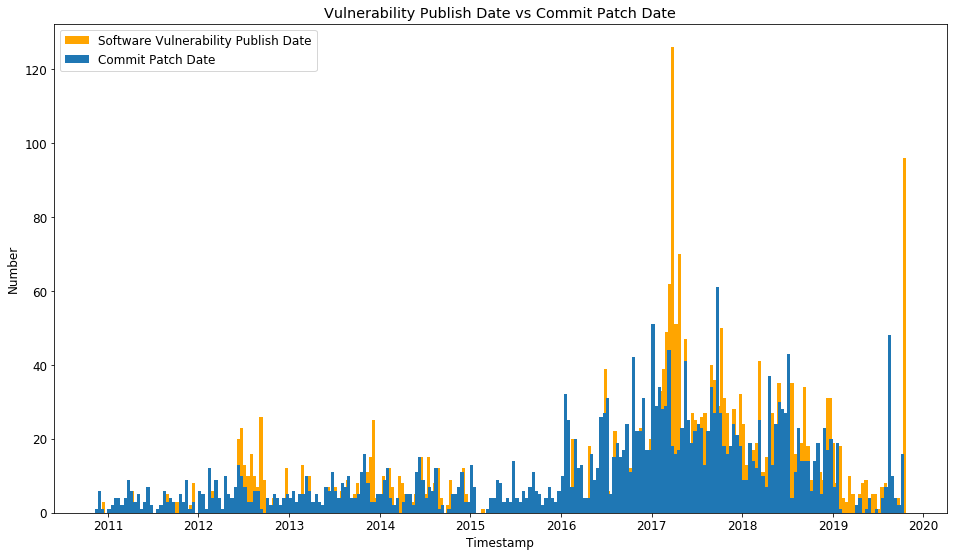

In [19]:
plt.hist(patched_vulns['published_date'], bins=250, color='orange', label='Software Vulnerability Publish Date')
plt.hist(patched_vulns['commit_date'], bins=250, label='Commit Patch Date')
plt.legend(loc='upper left')
plt.title('Vulnerability Publish Date vs Commit Patch Date')
plt.xlabel('Timestamp')
plt.ylabel('Number')
plt.show()

This seems to show that software vulnerabilities aren't officially recognized/published by the NVD until some duration after the vulnerability is patched/fixed. Hmmm, that's interesting...

In [20]:
patched_vulns['commit_date'] = pd.to_datetime(patched_vulns['commit_date'])
monthly_fixes = resample(patched_vulns['commit_date'], 'm')

#### Kernel Density Estimation for Vulnerability Fixes Per Month

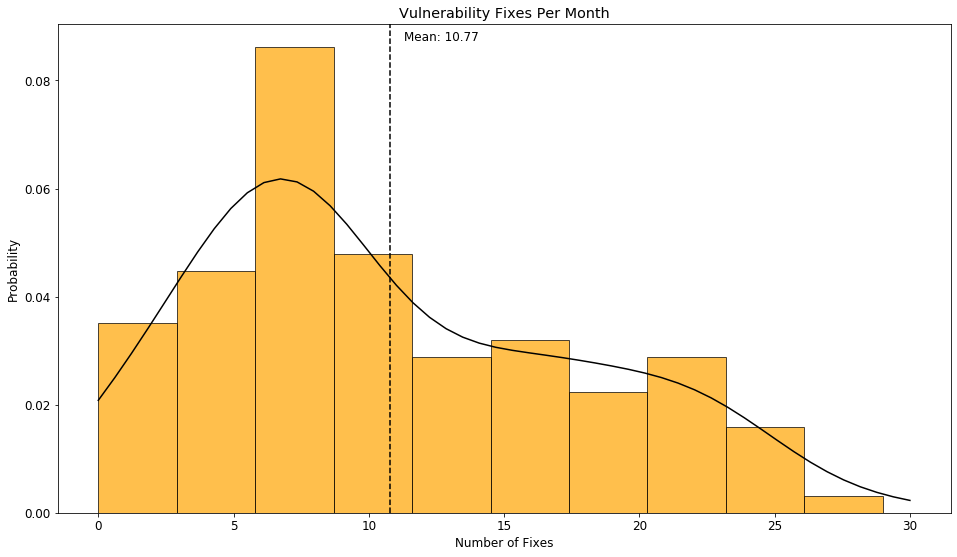

In [22]:
from scipy.stats import kde
from scipy.stats import norm
import numpy as np

mu,std = norm.fit(monthly_fixes)
median = monthly_fixes.median()

plt.hist(monthly_fixes, alpha=0.7, bins=10, density=True, ec='black', color='orange')
xvals = np.linspace(0, 30)
density = kde.gaussian_kde(monthly_fixes, bw_method=None)
xgrid = np.linspace(xvals.min(), xvals.max(), 100)
plt.plot(xvals, density(xvals), color='black')

min_ylim, max_ylim = plt.ylim()

# display mean
plt.axvline(mu, color='black', linestyle='dashed')
plt.text(mu*1.05, max_ylim*0.965, 'Mean: {:.2f}'.format(mu))

plt.title('Vulnerability Fixes Per Month')
plt.xlabel('Number of Fixes')
plt.ylabel('Probability')
plt.show()

In [133]:
# the number of days after the patch that NVD published the vulnerability info
# positive values means the NVD published the vulnerability info after it was fixed
# negative values means the vulnerability was fixed after it was published by the NVD
days_until_published = []

for diff in pd.to_datetime(patched_vulns['published_date']) -  pd.to_datetime(patched_vulns['commit_date']):
    days_until_published.append(diff.days)
        
delay = pd.DataFrame(days_until_published) 
delay.columns = ['days_until_published_by_nvd']

temp = patched_vulns.copy()
temp['days_until_published_by_nvd'] = delay

In [134]:
# clean up the data
# exclude negative days
for i, row in temp.iterrows():
    if row['days_until_published_by_nvd'] < 0:
        temp = temp.drop(i)
    
# exclude days over 3 years
for i, row in temp.iterrows():
    if row['days_until_published_by_nvd'] > 1095:
        temp = temp.drop(i)

In [135]:
days_elapsed = temp['days_until_published_by_nvd']
print(days_elapsed.describe())

count    2533.000000
mean      135.827872
std       209.500051
min         0.000000
25%        13.000000
50%        44.000000
75%       154.000000
max      1088.000000
Name: days_until_published_by_nvd, dtype: float64


### Distribution Modeling

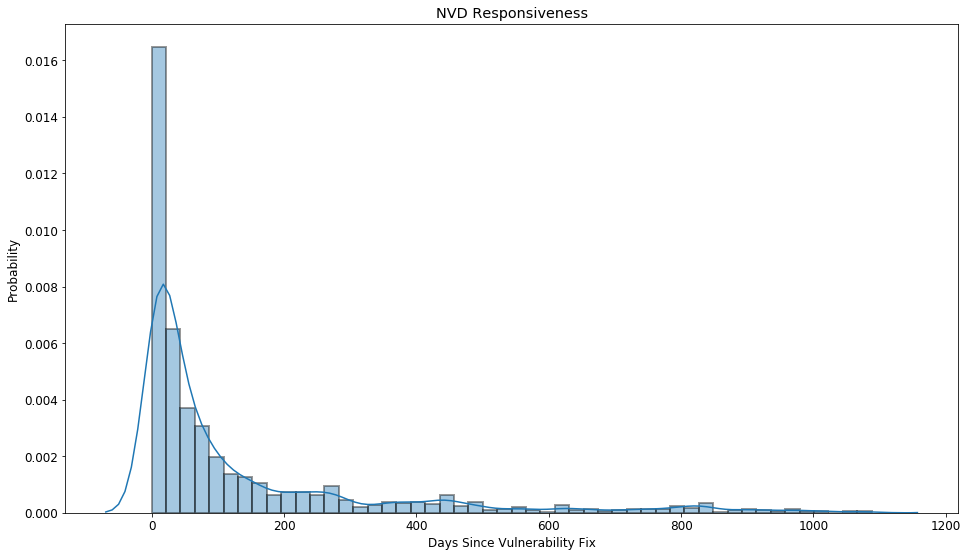

In [137]:
import seaborn as sns

sns.distplot(days_elapsed, hist_kws=dict(edgecolor='black', linewidth=2))

plt.title('NVD Responsiveness')
plt.xlabel('Days Since Vulnerability Fix')
plt.ylabel('Probability')
plt.show()

This distribution models how many days it takes the NVD to publish new vulnerability info, after the vulnerability has been fixed by a **github commit**.

### Hypothesis Testing
#### H0: The NVD publishes new vulnerability information <= 4 months after there was a commit that patched the vulnerability.
#### H1: The NVD publishes new vulnerability information > 4 months after there was a commit that patched the vulnerability.

In [157]:
import statsmodels.api as sm
z, p = sm.stats.ztest(days_elapsed, value = 120, alternative = 'larger')
print('z-statistic =', z)
print('p-value =', p)

z-statistic = 3.802384177184126
p-value = 7.165513495690412e-05


### Conclusion
Since the p-value (7.17e-05) is significantly lower than the standard confidence level 0.05, we can reject the null hypothesis (H0). There is strong evidence in support for the alternative hypothesis (H1), that the avgerage time it takes the NVD to publish new vulnerability info after the vulnerability has been patched, is **greater than 4 months**.

#### Correlation between vulnerability publish date and commit patch date.

In [150]:
vulns_d = resample(patched_vulns['published_date'], 'd')
commits_d = resample(patched_vulns['commit_date'], 'd')

vulns_w = resample(patched_vulns['published_date'], 'w')
commits_w = resample(patched_vulns['commit_date'], 'w')

vulns_m = resample(patched_vulns['published_date'], 'm')
commits_m = resample(patched_vulns['commit_date'], 'm')

vulns_y = resample(patched_vulns['published_date'], 'y')
commits_y = resample(patched_vulns['commit_date'], 'y')

corr_d = vulns_d.corr(commits_d)
corr_w = vulns_w.corr(commits_w)
corr_m = vulns_m.corr(commits_m)
corr_y = vulns_y.corr(commits_y)

print('Correlations between vulnerability publish date and commit patch date:')
print('\tDaily:', corr_d)
print('\tWeekly:', corr_w)
print('\tMonthly:', corr_m)
print('\tYearly:', corr_y)

Correlations between vulnerability publish date and commit patch date:
	Daily: 0.22593895093776428
	Weekly: 0.5397910039757639
	Monthly: 0.7007923478588983
	Yearly: 0.8207071482059372


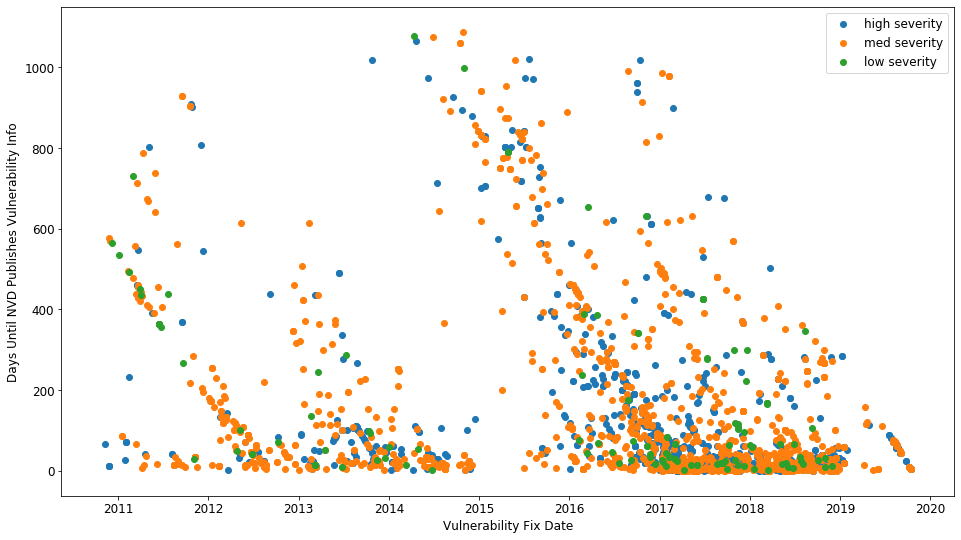

In [190]:
# high severity >= 6.66
high = temp[temp['base_score'] >= 6.66]
# med severity > 3.33 and < 6.66
med = temp[(temp['base_score'] > 3.33) & (temp['base_score'] < 6.66)]
# low severity < 3.33
low = temp[temp['base_score'] <= 3.33]

x = high['commit_date']
y = high['days_until_published_by_nvd']

x1 = med['commit_date']
y1 = med['days_until_published_by_nvd']

x2 = low['commit_date']
y2 = low['days_until_published_by_nvd']

plt.scatter(x, y, label='high severity')
plt.scatter(x1, y1, label='med severity')
plt.scatter(x2, y2, label='low severity')
plt.legend(scatterpoints=1, loc='upper right')

plt.xlabel('Vulnerability Fix Date')
plt.ylabel('Days Until NVD Publishes Vulnerability Info')
plt.show()

Hmmm, you would think the NVD would published info about severe vulnerabilties in a quicker fashion...